# Köpekler ve Kediler Görüntü Sınıflandırması (Veri Seti Büyütme Olmadan)

Bu başlık altında, resimlerdeki kedi ve köpek resimlerini nasıl sınıflandıracağımızı bulacağız. `tf.keras.Sequential` modelini kullanarak bir görüntü sınıflandırıcı oluşturacağız. Bununla beraber `tf.keras.preprocessing.image.ImageDataGenerator` veri setlerimizi yükleyeceğiz.

## Başlamadan Bakmamız Gereken Birkaç Bilgi
Bu colab dosyası ile pratik bir deneyim elde etmiş olacağız.
* `tf.keras.preprocessing.image.ImageDataGenerator` sınıfını kullanarak veri girişini nasıl alacağız? Modelimizi oluşturmak için diskteki verileri nasıl verimli bir şekilde çalıştırabiliriz?

* Aşırı uyum (*overfitting*) nedir?

<hr>

**Başlamadan önce**

Kod satırlarını bu not defterinde çalıştırmadan önce, yukarıdaki menüden Çalışma Zamanı -> Çalışma Zamanını Yeniden Başlat seçeneklerini takip ederek çalışma zamanını sıfırlayın. Bunu yapmamız, Colab'ın bellek sınırlarına ulaşmaktan kaçınmamıza yardımcı olacaktır.


## Paketlerin İçe Aktarılması

Gerekli paketleri içe aktararak başlayalım:

* os — dosyaları ve dizin yapısını okumak için kullanılır.
* numpy — TensorFlow'un dışındaki bazı matris matematiği için gereklidir.
* matplotlib.pyplot —  grafikleri, eğitim ve doğrulama verilerimizi görüntülemek için kullanılır.

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Verilerin Yüklenmesi

Görüntü sınıflandırı oluşturmak için ver setini indirerek başlıyoruz. Kullandığımız veri kümesi, Kaggle'ın <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> veri kümesi olacak.(Bu veri kümesi Microsoft Research tarafından sağlanmaktadır.)

Önceki colab dosyalarında, veri kümesi kullanmanın çok kolay ve kullanışlı bir yolu olan <a href="https://www.tensorflow.org/datasets" target="_blank">TensorFlow Datasets</a> kullandık. Ancak bu colab dosyasında diskten veri okuyacak olan `tf.keras.preprocessing.image.ImageDataGenerator` sınıfını kullanacağız. Bu nedenle, Dogs vs Cats veri setimizi bir URL'den doğrudan indirmemiz ve dosya sistemine açmamız gerekiyor.

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 0s 0us/step


İndirmiş olduğumuz veri seti aşağıdaki dizin yapısına sahiptir:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Dizinleri aşağıdaki terminal komutlarıyla listeleyebiliriz:

In [6]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


Şimdi eğitim ve doğrulama kümeleri için uygun dosya yolları değişkenlere atayacağız.

In [7]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # eğitim kedi resimlerimizin olduğu dizin
train_dogs_dir = os.path.join(train_dir, 'dogs')  # eğitim köpek resimlerimizin olduğu dizin
validation_cats_dir = os.path.join(validation_dir, 'cats')  # doğrulama kedi resimlerimizin olduğu dizin
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # doğrulama köpek resimlerimizin olduğu dizin

### Verilerimizi Anlayalım

Eğitim ve doğrulama dizinimizde kaç tane kedi ve köpek resmimiz olduğuna bakalım.

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('Eğitim veri setindeki toplam kedi resmi :', num_cats_tr)
print('Eğitim veri setindeki toplam köpek resmi:', num_dogs_tr)

print('Doğrulama veri setindeki toplam kedi resmi :', num_cats_val)
print('Doğrulama veri setindeki toplam köpek resmi:', num_dogs_val)
print("--")
print("Toplam eğitim veri seti görüntülerimiz :", total_train)
print("Toplam doğrulama veri seti görüntülerimiz : ", total_val)

Eğitim veri setindeki toplam kedi resmi : 1000
Eğitim veri setindeki toplam köpek resmi: 1000
Doğrulama veri setindeki toplam kedi resmi : 500
Doğrulama veri setindeki toplam köpek resmi: 500
--
Toplam eğitim veri seti görüntülerimiz : 2000
Toplam doğrulama veri seti görüntülerimiz :  1000


## Model Parametrelerinin Ayarlanması

Kolaylık sağlaması için daha sonra veri setimizi işlerken ve ağımızı eğitirken kullanılacak değişkenleri tanımlayalım:

In [10]:
BATCH_SIZE = 100  # Model değişkenlerimizi güncellemeden önce işlenecek eğitim örneklerinin sayısı
IMG_SHAPE  = 150  # Eğitim verilerimiz 150 piksel genişliğinde ve 150 piksel yüksekliğinde görüntülerden oluşmaktadır.

## Verilerin Hazırlanması

Görüntüler, ağı beslemeden önce uygun şekilde önceden işlenmiş kayan nokta (floating point) tensörlerine biçimlendirilmelidir. Bu görüntülerin hazırlanmasında yer alan adımlar şu şekildedir:

1. Diskten görüntülerin okunması.
2. Bu görüntülerin RGB içeriklerine göre uygun ızgara formatına dönüştürülmesi.
3. Bunların kayan nokta (floating point) tensörlerine dönüştürülmesi.
4. Sinir ağları küçük giriş değerleriyle uğraşmayı tercih ettiği için tensörlerin `0-255` değerleri aralığından `0-1` arasındaki değerlere yeniden ölçeklendirilmesi.

Neyse ki tüm bu görevler `tf.keras.preprocessing.image.ImageDataGenerator` sınıfı kullanılarak yapılabilir.

Bunları birkaç kod satırı ile ayarlayabiliriz.



In [11]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Eğitim veri seti için
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Doğrulama veri seti için

Eğitim ve doğrulama görüntüleri oluşturucularımızı tanımladıktan sonra `flow_fromn_directory` yöntemi ile görüntüleri diskten okuruz, yeniden ölçeklendiririz ve yeniden boyutlandırırız. Ve bunların hepsini tek bir satır kodla yapabilirsiniz !

In [12]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Eğitim Görüntülerinin Görselleştirilmesi

Eğitim görüntülerimizi, eğitim oluşturucudan (training generator) bir grup görüntü alarak ve ardından `matplotlib` kullanarak görselleştirebiliriz.

In [14]:
sample_training_images, _ = next(train_data_gen) 

`next` işlevi, veri kümesinden toplu bir iş döndürür. Bi toplu iş, bit demettir (tuple). Şu an için etiketleri almadan sadece resimlere bakıyoruz.

In [15]:
# Bu işlev, 1 satır ve 5 sütunlu bir ızgaraya görüntüleri yerleştirecektir.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

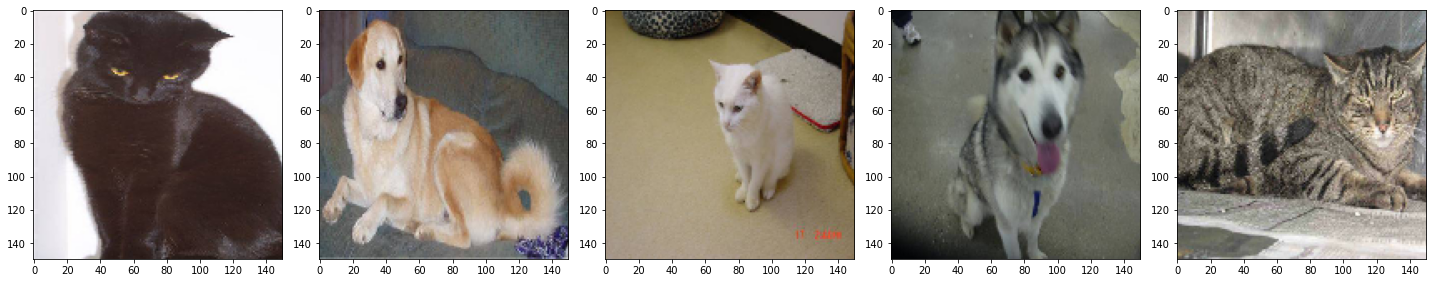

In [16]:
plotImages(sample_training_images[:5]) # 0-4 arası görüntüleri gösterelim

## Modelin Oluşturulması

### Modelin Tanımlanması

Model, her birinde maksimum havuz katmanı bulunan dört evrişim bloğundan oluşur. Ardından, `relu` yeniden  etkinleştirme işlevine sahip 512 üniteli tam bağlantılı bir katmanımız var. Model, `softmax` kullanarak iki sınıf (köpekler ve kediler) için sınıf olasılıkları çıkaracaktır.

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Modelin Derlenmesi

Her zamanki gibi `adam` optimize edici kullanıyoruz. Bir `softmax` kategorizasyonu ürettiğimizde, kayıp fonksiyonu olarak (loss func) `sparse_categorical_crossentropy` kullanacağız. Ayrıca ağımızı eğitirken her bir yineleme de (epoch) eğitim ve doğrulama durumuna bakmak istiyoruz, bu nedenle metrik argümanını `accuracy` (doğruluk) olarak seçiyoruz.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Özetimiz

Özet yöntemini kullanarak ağımızın tüm katmanlarına bakalım.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Modelin Eğitilmesi

Ağımızı eğitme zamanı geldi.

Gruplarımız bir oluşturucudam (ImageDataGenerator), `fit` yerine `fit_generator` kullanacağız.

In [20]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 41s 419ms/step - loss: 0.7173 - accuracy: 0.5105 - val_loss: 0.7186 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 8s 426ms/step - loss: 0.6910 - accuracy: 0.5725 - val_loss: 0.6734 - val_accuracy: 0.6510
Epoch 3/100
20/20 [==============================] - 8s 425ms/step - loss: 0.6656 - accuracy: 0.5930 - val_loss: 0.6498 - val_accuracy: 0.5560
Epoch 4/100
20/20 [==============================] - 8s 414ms/step - loss: 0.6228 - accuracy: 0.6480 - val_loss: 0.6985 - val_accuracy: 0.5900
Epoch 5/100
20/20 [==============================] - 8s 401ms/step - loss: 0.5643 - accuracy: 0.7085 - val_loss: 0.5787 - val_accuracy: 0.6960
Epoch 6/100
20/20 [==============================] - 8s 399ms/step - loss: 0.5370 - accuracy: 0.7220 - val_loss: 0.5942 - val_accuracy: 0.6850
Epoch 7/100
20/20 [==============================] - 8s 397ms/step - loss: 0.5393 - accuracy: 0.7280 - val_loss: 0.5641 - val_accuracy: 0.712

### Eğitim sonuçlarını görüntüleyelim.

Şimdi ağımızı eğittikten sonra elde ettiğimiz sonuçları görselleştirelim.

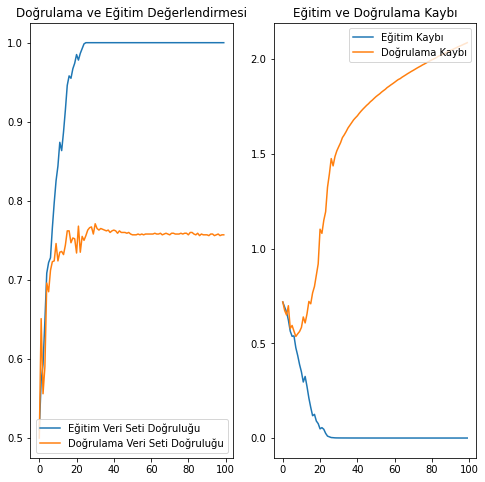

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Veri Seti Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Veri Seti Doğruluğu')
plt.legend(loc='lower right')
plt.title('Doğrulama ve Eğitim Değerlendirmesi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.savefig('./foo.png')
plt.show()

Grafiklerde görebileceğimiz gibi modelimiz doğrulama setinde yalnızca yaklaşık %75 doğruluk elde etmiştir. (epoch parametresine bağlı olarak)

Bu durum, aşırı uyumun (*overfitting*) açık bir göstergesidir. Eğitim ve doğrulama eğrileri ayrılmaya başladığında, modelimiz eğitim verilerini ezberlemeye başlar. Bu durum neticesinde, doğrulama verileri üzerinde iyi performans göstermez.